In [1]:
import xarray as xr
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import rioxarray

In [2]:
# Load NDVI data
ndvi_data = xr.open_dataset(r"C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\INDIA_NDVI_1KM\MOD13A3.061_1km_aid0001.nc")

In [3]:
# Load India shapefile & extract geometry
india_shapefile = gpd.read_file(r"C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\SHAPEFILE\gadm36_IND_0.shp")
india_geometry = india_shapefile.geometry

In [4]:
# Keep only the NDVI data, not the quality data
ndvi_data = ndvi_data["_1_km_monthly_NDVI"]

In [5]:
# Project to WGS84
ndvi_data = ndvi_data.rio.write_crs("EPSG:4326")

In [6]:
# Convert Julian date to correct format
datetimeindex = ndvi_data.indexes['time'].to_datetimeindex()
ndvi_data['time'] = datetimeindex

C:\Users\djava\AppData\Local\Temp\ipykernel_944\2480628301.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = ndvi_data.indexes['time'].to_datetimeindex()


### Resample CropGrids data and mask NDVI data with it

In [7]:
# Load cropgrids data
cropgrids_data = xr.open_dataset(r"C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\CROPGRIDS\CROPGRIDSv1.06_rice.nc")

# keep only the "harvarea" variable
cropgrids_data = cropgrids_data["cultarea"]

# We first have to set the crs of the climate data and the resampled climate data
cropgrids_data.rio.write_crs("EPSG:4326", inplace=True)
# cropgrids_data = cropgrids_data.squeeze()

cropgrids_data = cropgrids_data.rio.clip(india_geometry)

In [8]:
cropgrids_data_interp = cropgrids_data.interp_like(ndvi_data, method='nearest')

In [9]:
# ndvi_data_test = ndvi_data.isel(time=0)

In [10]:
# # Interpolate crop location data to match NDVI data grid
# crop_data_interp = crop_data.interp_like(ndvi_data_test, method='nearest')

In [11]:
# Assuming ndvi_data is your NDVI xarray DataArray
ndvi_rice_only = ndvi_data.where(cropgrids_data_interp > 100)

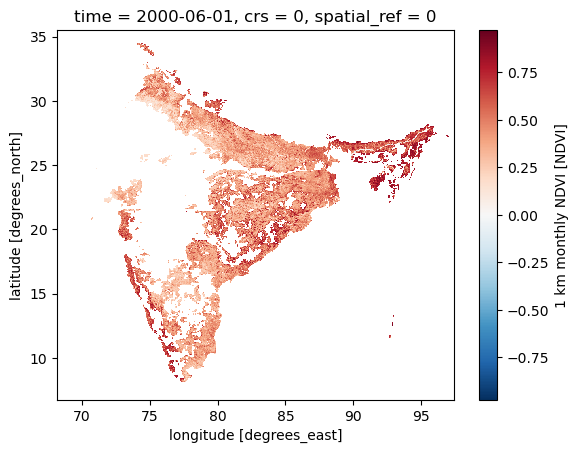

In [12]:
# plot ndvi_rice_only for first time step
ndvi_rice_only.isel(time=2).plot()

#### Zonal statistics

In [13]:
# Load India districts shapefile
india_districts_shapefile = gpd.read_file(r"C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\SHAPEFILE\gadm36_IND_2.shp")

In [14]:
# Reset index in preparation for zonal statistics
india_districts_shapefile = india_districts_shapefile.reset_index()
india_districts_shapefile.head()

,index,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,0,IND,India,IND.1_1,Andaman and Nicobar,NaN,IND.1.1_1,Nicobar Islands,NaN,NaN,District,District,NaN,IN.AN.NI,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
1,1,IND,India,IND.1_1,Andaman and Nicobar,NaN,IND.1.2_1,North and Middle Andaman,NaN,NaN,District,District,NaN,IN.AN.NM,"MULTIPOLYGON (((92.93898 12.22386, 92.93916 12..."
2,2,IND,India,IND.1_1,Andaman and Nicobar,NaN,IND.1.3_1,South Andaman,NaN,NaN,District,District,NaN,IN.AN.SA,"MULTIPOLYGON (((92.47972 10.52056, 92.47945 10..."
3,3,IND,India,IND.2_1,Andhra Pradesh,NaN,IND.2.1_1,Anantapur,"Anantpur, Ananthapur",NaN,District,District,NaN,IN.AD.AN,"POLYGON ((77.71420 13.76079, 77.71314 13.75074..."
4,4,IND,India,IND.2_1,Andhra Pradesh,NaN,IND.2.2_1,Chittoor,Chitoor|Chittor,NaN,District,District,NaN,IN.AD.CH,"POLYGON ((78.46293 12.63537, 78.46190 12.63228..."


In [15]:
import regionmask

In [16]:
# 1. Create mask from shapefile and xarray climate_data
mask = regionmask.from_geopandas(india_districts_shapefile, 
                                 names="GID_2", 
                                 abbrevs="_from_name").mask(ndvi_rice_only['lon'],
                                                            ndvi_rice_only['lat'])

In [17]:
# 2. Aggregate variables in the xarray using the mask
regional_agg_dr = ndvi_rice_only.groupby(mask).mean() # max, min, mapping custom functions also work

In [18]:
# 3. Convert the aggregated xarray to a dataframe
regional_agg = regional_agg_dr.to_dataframe()
regional_agg.reset_index(inplace=True)

In [19]:
# add region information and drop mask column
regional_agg['GID_2'] = regional_agg.apply(lambda x: india_districts_shapefile['GID_2'][int(x['mask'])], axis=1)
regional_agg = regional_agg.drop(columns=['mask'])
regional_agg = regional_agg.drop(columns=['crs'])

In [20]:
regional_agg

,time,spatial_ref,_1_km_monthly_NDVI,GID_2
0,2000-04-01,0,NaN,IND.1.1_1
1,2000-04-01,0,0.787978,IND.1.2_1
2,2000-04-01,0,0.754148,IND.1.3_1
3,2000-04-01,0,0.252421,IND.2.1_1
4,2000-04-01,0,0.320512,IND.2.2_1
...,...,...,...,...
181813,2022-12-01,0,0.449403,IND.36.16_1
181814,2022-12-01,0,0.442796,IND.36.17_1
181815,2022-12-01,0,0.444508,IND.36.18_1
181816,2022-12-01,0,0.449851,IND.36.19_1


In [21]:
# save to excel
regional_agg.to_excel(r"C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\PROCESSED_DATA\NDVI\ndvi_rice_only.xlsx")

In [18]:
NDVI_data_set = ndvi_rice_only.to_dataset(name='NDVI')

In [19]:
NDVI_data_set

<xarray.Dataset>
Dimensions:      (time: 273, lat: 3451, lon: 3508)
Coordinates:
  * time         (time) datetime64[ns] 2000-04-01 2000-05-01 ... 2022-12-01
  * lat          (lat) float64 35.5 35.5 35.49 35.48 ... 6.779 6.771 6.762 6.754
  * lon          (lon) float64 68.19 68.2 68.2 68.21 ... 97.39 97.4 97.4 97.41
    crs          int32 0
    spatial_ref  int32 0
Data variables:
    NDVI         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

In [20]:
# Create mask of multiple regions from shapefile
india_mask = regionmask.mask_3D_geopandas(
        india_districts_shapefile,
        NDVI_data_set.lon,
        NDVI_data_set.lat,
        drop=True,
        numbers="index"
    )

In [22]:
# Apply the mask to the xarray data
ndvi_rice_only_data_masked = NDVI_data_set.isel(time=1).where(india_mask)

In [23]:
ndvi_rice_only_data_masked

<xarray.Dataset>
Dimensions:      (lat: 3451, lon: 3508, region: 666)
Coordinates:
    time         datetime64[ns] 2000-05-01
  * lat          (lat) float64 35.5 35.5 35.49 35.48 ... 6.779 6.771 6.762 6.754
  * lon          (lon) float64 68.19 68.2 68.2 68.21 ... 97.39 97.4 97.4 97.41
    crs          int32 0
    spatial_ref  int32 0
  * region       (region) int32 0 1 2 3 4 5 6 7 ... 659 660 661 662 663 664 665
Data variables:
    NDVI         (lat, lon, region) float32 nan nan nan nan ... nan nan nan nan